In [1]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, DotProduct
from sklearn.preprocessing import scale
from matplotlib import cm
from helper import plot_gp, plot_gps

os.chdir(Path('.').absolute().parent)
from analyzer import bayesian_optimizer, util
from analyzer.bayesian_optimizer_pool import BayesianOptimizerPool as BOP

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# load cloud perf dataframe
df = pd.read_pickle('cloud_perf_b8000.0.pkl')
df.head()

,budget:,cost,feature,nodetype,price,qos,qos_over_cost
0,150,120.96,"[0.03125, 0.69696969697, 0.015625, 0.5, 0.0622...",r4.xlarge,0.168,32000.0,264.550265
1,150,578.88,"[0.0625, 0.727272727273, 0.03125, 0.05, 0.0714...",d2.2xlarge,0.804,64000.0,110.558320
2,150,1365.12,"[0.25, 0.787878787879, 0.030737704918, 0.5, 0....",g2.8xlarge,1.896,256000.0,187.529301
3,150,68.40,"[0.015625, 0.757575757576, 0.00384221311475, 0...",m3.large,0.095,16000.0,233.918129
4,150,105.12,"[0.03125, 0.848484848485, 0.00384221311475, 0....",c3.xlarge,0.146,32000.0,304.414003


In [3]:
# sort by qos/cost
df.sort_values('qos_over_cost', ascending=False).head()

,budget:,cost,feature,nodetype,price,qos,qos_over_cost
31,150,3.024,"[0.0078125, 1.0, 0.000256147540984, 0.005, 0.0...",t2.nano,0.0042,8000.0,2645.502646
59,150,6.048,"[0.0078125, 1.0, 0.000512295081967, 0.015, 0.0...",t2.micro,0.0084,8000.0,1322.751323
20,150,10.080,"[0.0078125, 0.69696969697, 0.000314036885246, ...",t1.micro,0.0140,8000.0,793.650794
51,150,12.096,"[0.0078125, 1.0, 0.00102459016393, 0.015, 0.07...",t2.small,0.0168,8000.0,661.375661
30,150,24.192,"[0.015625, 1.0, 0.00204918032787, 0.015, 0.071...",t2.medium,0.0336,16000.0,661.375661


In [4]:
# sort by qos
df.sort_values('qos', ascending=False).head()

,budget:,cost,feature,nodetype,price,qos,qos_over_cost
43,150,5917.68,"[1.0, 0.69696969697, 1.0, 0.05, 0.714285714286]",x1.32xlarge,8.219,1024000.0,173.040786
8,150,7076.16,"[0.5, 0.69696969697, 0.393442622951, 1.0, 0.71...",p2.16xlarge,9.828,512000.0,72.355628
52,150,1935.36,"[0.5, 0.69696969697, 0.25, 1.0, 1.0]",r4.16xlarge,2.688,512000.0,264.550265
55,150,2959.20,"[0.5, 0.69696969697, 0.5, 0.05, 0.357142857143]",x1.16xlarge,4.110,512000.0,173.019735
72,150,2467.44,"[0.5, 0.69696969697, 0.25, 1.0, 1.0]",i3.16xlarge,3.427,512000.0,207.502513


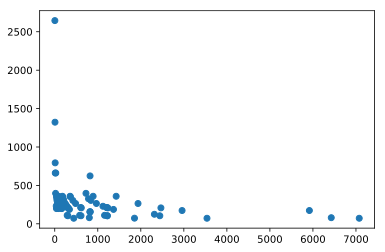

In [5]:
# cost vs qos/cost
plt.scatter(df['cost'], df['qos_over_cost'])

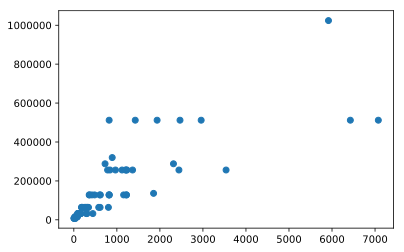

In [6]:
# cost vs cost
plt.scatter(df['cost'], df['qos'])

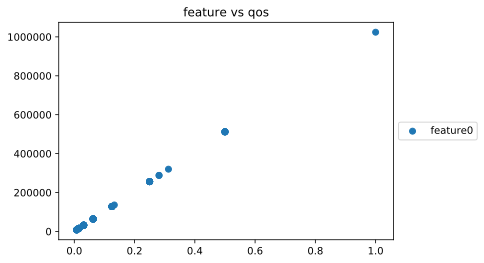

In [7]:
# feature 0 vs qos
plt.scatter(df.feature.apply(lambda x: x[0]), df.qos, label='feature0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('feature vs qos')

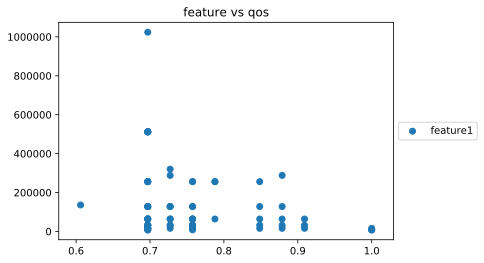

In [8]:
# feature 1 vs qos
plt.scatter(df.feature.apply(lambda x: x[1]), df.qos, label='feature1')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('feature vs qos')

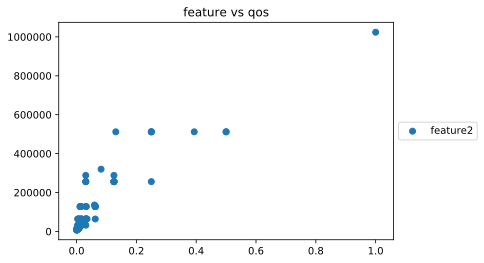

In [9]:
# feature 2 vs qos
plt.scatter(df.feature.apply(lambda x: x[2]), df.qos, label='feature2')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('feature vs qos')

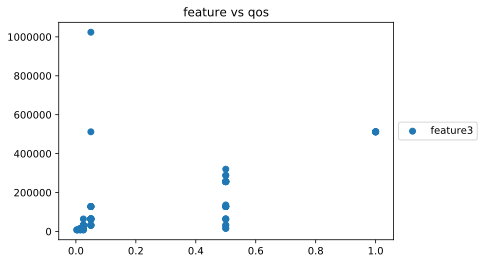

In [10]:
# feature 3 vs qos
plt.scatter(df.feature.apply(lambda x: x[3]), df.qos, label='feature3')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('feature vs qos')

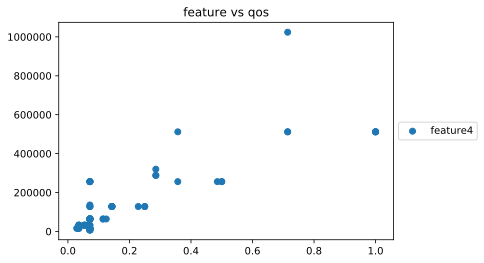

In [11]:
# feature 4 vs qos
plt.scatter(df.feature.apply(lambda x: x[4]), df.qos, label='feature4')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('feature vs qos')

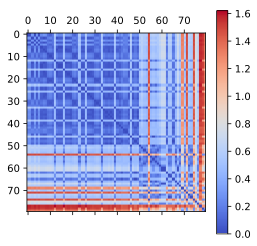

In [ ]:
# euclidean distance of encoded normalized features 
df = df.sort_values('cost')
features = np.array(df['nodetype'].apply(util.encode_nodetype).tolist())
n = len(df['nodetype'])
heatmap = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        heatmap[i, j] = util.feature_distance(features[i], features[j])

plt.matshow(heatmap, cmap='coolwarm')
plt.colorbar()

In [ ]:
# covariance matrix of encoded normalized features 
for n in [0.5, 1.5, 2.5]:
    for l in [0.1, 1, 10]:
        Kernel = Matern(nu=n, length_scale=l)

        plt.matshow(Kernel(features), cmap='coolwarm')
        plt.colorbar()
        plt.title(f'{Kernel}\n')


In [ ]:
# covariance matrix of encoded normalized features
for s in [0.1, 1, 10]:
    Kernel = DotProduct(sigma_0=s)

    plt.matshow(Kernel(features), cmap='coolwarm')
    plt.title(f'{Kernel}\n')
    plt.colorbar()

In [ ]:
gp_params = {"alpha": 1e-10, "n_restarts_optimizer": 25,
             "kernel": Matern(nu=2.5), "random_state": 6}
# shuffles 
np.random.seed(6)
shuffled_df = df.iloc[np.random.permutation(len(df))]

In [ ]:
X = np.array([util.encode_nodetype(n) for n in shuffled_df['nodetype'].tolist()])
y_qoc = np.array(shuffled_df['qos_over_cost'])
y_q = np.array(shuffled_df['qos'])
y_c = np.array(shuffled_df['cost'])

y_q /= 100000000
y_qoc /= 1000000

x = X[:,:1].reshape(-1,1)
x_sorted, y_q_sorted, y_qoc_sorted, y_c_sorted = zip(*sorted(zip(x, y_q, y_qoc, y_c)))
x_sorted, y_q_sorted, y_qoc_sorted, y_c_sorted = np.array(x_sorted), np.array(y_q_sorted), np.array(y_qoc_sorted), np.array(y_c_sorted)

In [ ]:
# visualize only first dimension Qos
np.set_printoptions(10)
n_init = 4
X_train_ = X[:n_init, :1]
y_train_ = y_q[:n_init] # qos objective

gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train_, y_train_)


utility = bayesian_optimizer.UtilityFunction(kind='ei', gp_objective=gp)
print(np.count_nonzero(utility))
candidate = x[np.argmax(utility)]
print(f'train_x: {X_train_}')
print(f'argmax_x: {candidate}')
# feature 0 vs qos
plot_gp(gp, x_sorted, y_q_sorted, utility, xlim=(min(x)-0.1, max(x)+0.1))


In [ ]:
# visualize only first dimension Qos
n_init = 10
X_train_ = X[:n_init, :1]
y_train_ = y_qoc[:n_init] # qos objective

gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train_, y_train_)

utility = bayesian_optimizer.UtilityFunction(kind='ei', gp_objective=gp)
print(np.count_nonzero(utility))
candidate = x[np.argmax(utility)]
print(f'X_train_: {X_train_}')
print(f'argmax_x: {candidate}')
# feature 0 vs qos
plot_gp(gp, x_sorted, y_qoc_sorted, utility, xlim=(min(x)-0.1, max(x)+0.1))



In [ ]:
X = np.array([util.encode_nodetype(n) for n in shuffled_df['nodetype'].tolist()])
y_qoc = np.array(shuffled_df['qos_over_cost'])
y_q = np.array(shuffled_df['qos'])
y_c = np.array(shuffled_df['cost'])

y_q /= 100000000
y_qoc /= 1000000

x = X[:,:1].reshape(-1,1)
x_sorted, y_q_sorted, y_qoc_sorted, y_c_sorted = zip(*sorted(zip(x, y_q, y_qoc, y_c)))
x_sorted, y_q_sorted, y_qoc_sorted, y_c_sorted = np.array(x_sorted), np.array(y_q_sorted), np.array(y_qoc_sorted), np.array(y_c_sorted)

In [ ]:
X = np.array([util.encode_nodetype(n) for n in shuffled_df['nodetype'].tolist()])
y_qoc = np.array(shuffled_df['qos_over_cost'])
y_q = np.array(shuffled_df['qos'])
y_c = np.array(shuffled_df['cost'])

y_q /= 100000000
y_qoc /= 1000000

x = X[:,:1].reshape(-1,1)
x_sorted, y_q_sorted, y_qoc_sorted, y_c_sorted = zip(*sorted(zip(x, y_q, y_qoc, y_c)))
x_sorted, y_q_sorted, y_qoc_sorted, y_c_sorted = np.array(x_sorted), np.array(y_q_sorted), np.array(y_qoc_sorted), np.array(y_c_sorted)

In [ ]:
# visualize only first dimension Qos
n_init = 10
X_train_ = X[:n_init, :1]
y_train_ = y_qoc[:n_init] # qos objective

gp = GaussianProcessRegressor()
gp.set_params(**gp_params)
gp.fit(X_train_, y_train_)

utility = bayesian_optimizer.UtilityFunction(kind='ei', gp_objective=gp)
print(np.count_nonzero(utility))
candidate = x[np.argmax(utility)]
print(f'X_train_: {X_train_}')
print(f'argmax_x: {candidate}')
# feature 0 vs qos
plot_gp(gp, x_sorted, y_qoc_sorted, utility, xlim=(min(x)-0.1, max(x)+0.1))


